# K-Nearest Neighbors Regression Model

Tutorial followed - https://towardsdatascience.com/knn-regression-model-in-python-9868f21c9fa2


**K-Nearest Neighbors (KNN) algorithm** - works by evaluating the "k" neighbours of a point to find similarities. One can use it for classification or regression. KNN rests on the principle that for one 'unknown' data point, similar data points are closer in space than dissimilar data points. Therefore, the unknown data point can be categorised as belonging to the 'nearest neighbour' data points.

**Linear Regression** - A statistical modeling tool to help predict values based on a linear relationship between the explanatory and response variables.


**KNN Regression** - Using the 'KNeighborsRegressor()' algorithm from the 'sklearn' library, the regression of a dataset is calculated and then the 'n_neighbors' parameter of the number chosen. Then, the results of these neighbors is checked and the results averaged.

In other words, "the target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set."

## Imports


In [2]:
#Data manipulation#
import pandas as pd
import numpy as np

#Data visualisation#
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

## Data


In [3]:
#Load in and view dataset#
df = sns.load_dataset('diamonds')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
#Shape of data#
print(f'No.rows: {df.shape[0]} | Columns (variables): {df.shape[1]}')

No.rows: 53940 | Columns (variables): 10


## Data Exploration

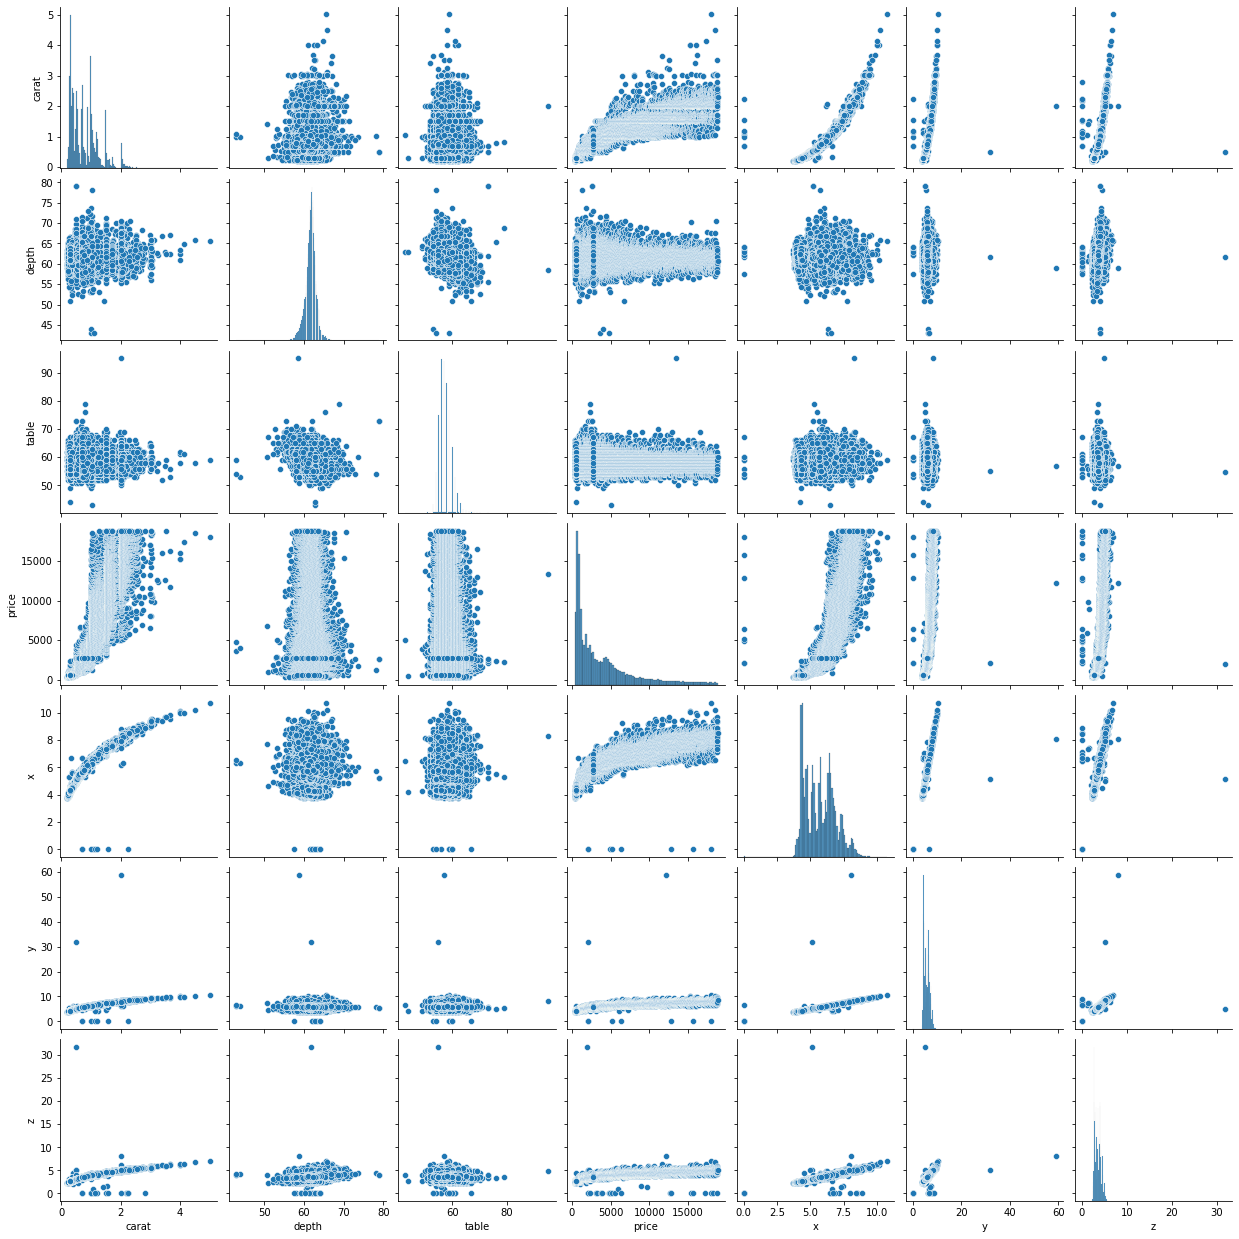

In [5]:
#Using a pairwise plot and table of the different variables,#
#see the best variables to model 'carat'#

sns.pairplot(df);


In [6]:
#Getting the table (correlations heatmapped)#

df.corr().style.background_gradient(cmap='coolwarm')


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


x, y and z correlate most with carat so they are good candidates to be modelled. Looking at the pairwise plot, y and z have an apparent linear relationship with the target variable carat whilst x has an exponential curve.

## Missing Values

In [7]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

## Train Test Split

To prevent *data leakage* (when parts of the training dataset leak into the response variable and influence model fitting, giving a false impression of a good fit), the data should be split now before any other formatting.

In [10]:
X = df[['x','y','z']]
y = df.carat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [11]:
print(f'Train: {X_train.shape, y_train.shape}  \nTest: {X_test.shape, y_test.shape}')

Train: ((43152, 3), (43152,))  
Test: ((10788, 3), (10788,))


## Removing Outliers

Linear regression can be affected by outliers that interfere with curve slope calculation. These can be removed by using the 1.5x IQR rule - every point above or below 1.5x the inter-quantile range is removed.

In [12]:
#Get descriptive stats for explanatory variables#
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
x,43152.0,5.731283,1.122783,0.0,4.71,5.69,6.54,10.74
y,43152.0,5.734739,1.150275,0.0,4.72,5.71,6.54,58.90
z,43152.0,3.538536,0.708813,0.0,2.91,3.53,4.03,31.80


In [13]:
#Extract quantiles#
x_25 = X_train.describe().T.loc['x', '25%']
x_75 = X_train.describe().T.loc['x', '75%']
y_25 = X_train.describe().T.loc['y', '25%']
y_75 = X_train.describe().T.loc['y', '75%']
z_25 = X_train.describe().T.loc['z', '25%']
z_75 = X_train.describe().T.loc['z', '75%']

#Calculate IQRs#
IQR_x = 1.5 * (x_75 - x_25)
IQR_y = 1.5 * (y_75 - y_25)
IQR_z = 1.5 * (z_75 - z_25)

Remove outliers.

In [14]:
#Remove outliers from the variable 'x'#
X_train = X_train.query(' x >= (@x_25 - @IQR_x) & x <= (@x_75 + @IQR_x) ')
y_train = y_train[X_train.index]

#Remove outliers from the variable 'y'#
X_train = X_train.query(' z >= (@y_25 - @IQR_y) & y <= (@y_75 + @IQR_y) ')
y_train = y_train[X_train.index]

#Remove outliers from the variable 'z'#
X_train = X_train.query(' x >= (@z_25 - @IQR_z) & z <= (@z_75 + @IQR_z) ')
y_train = y_train[X_train.index]

Next, the results should be checked.

Text(0.5, 1.0, 'Boxplot of z')

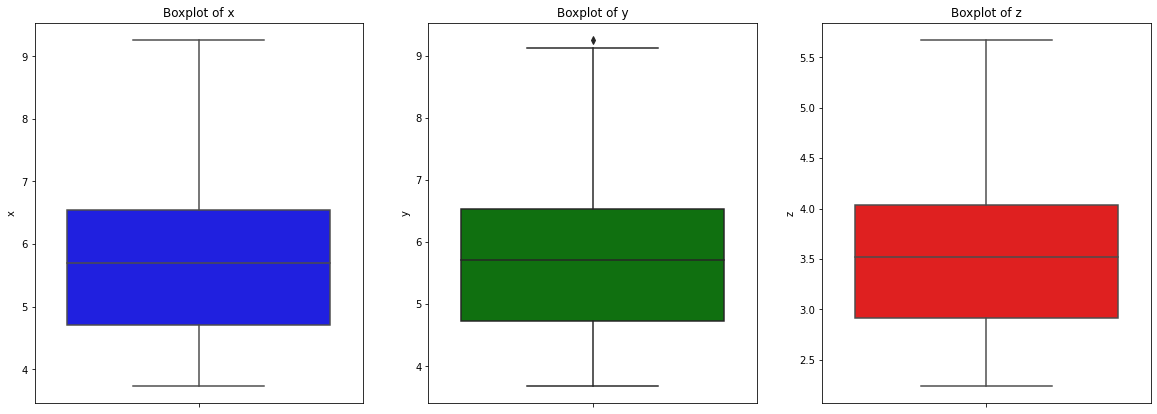

In [16]:
#Make figure#

fig, ax = plt.subplots(1,3, figsize=(20,7))

#Plot 1#

g1 = sns.boxplot(y=X_train.x, color='blue', ax=ax[0])
g1.set_title('Boxplot of x')

#Plot 2#

g2 = sns.boxplot(y=X_train.y, color='green', ax=ax[1])
g2.set_title('Boxplot of y')

#Plot 3#

g3 = sns.boxplot(y=X_train.z, color='red', ax=ax[2])
g3.set_title('Boxplot of z')

Below are some scatterplots to visualise the changes generated by removing outliers.

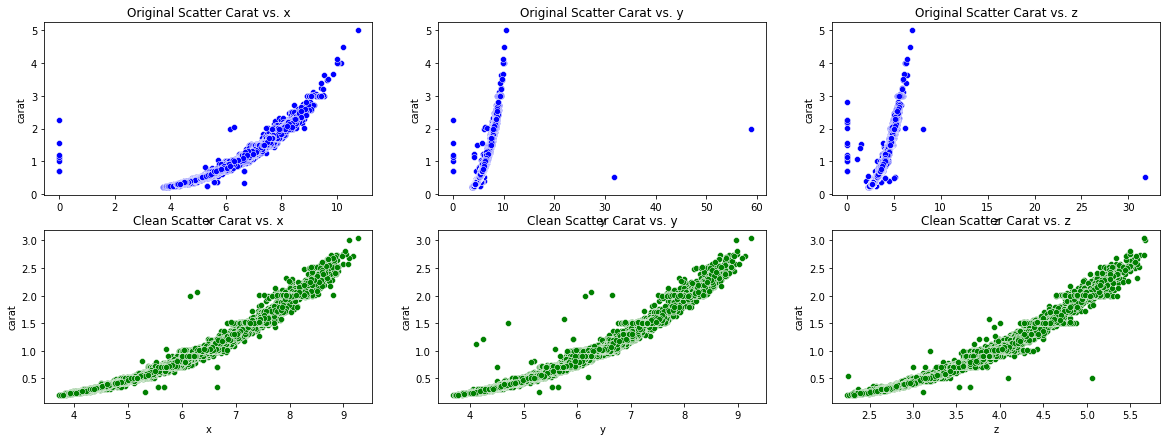

In [17]:
#Setup figure#
fig, ax = plt.subplots(2,3, figsize=(20,7))

for i, var in enumerate(['x', 'y', 'z']):
  # Original data plots
  g= sns.scatterplot(data= df, x=var, y='carat', color='blue', ax=ax[0][i])
  g.set_title(f'Original Scatter Carat vs. {var}')


df_clean = pd.concat([X_train, y_train], axis=1)

for i, var in enumerate(['x', 'y', 'z']):
  #Cleaned data plots#
  g= sns.scatterplot(data= df_clean, x=var, y='carat', color='green', ax=ax[1][i])
  g.set_title(f'Clean Scatter Carat vs. {var}')

One can see that the x,y,z vs carat relationships are almost linear albeit with a wee curve - some exponential degree that could be made linear with a log transformation.

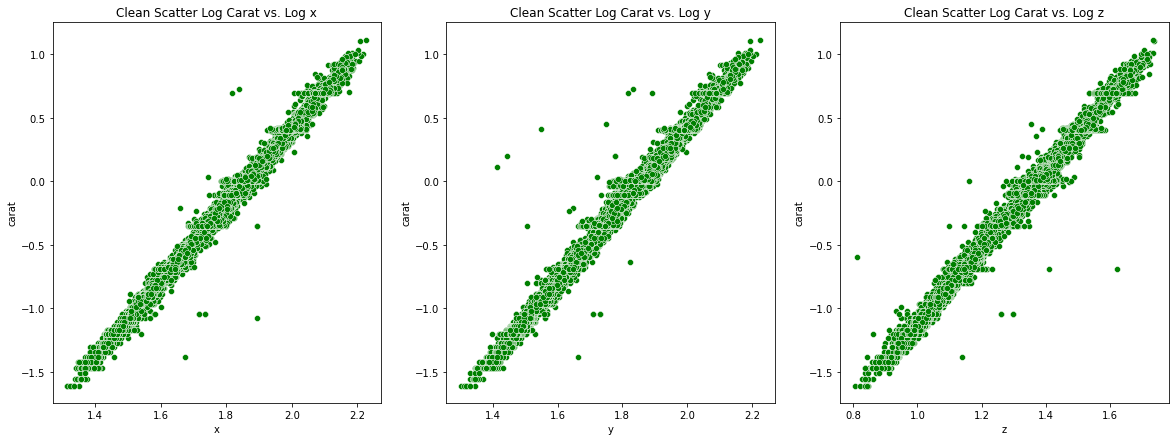

In [18]:
#Setup figure#
fig, ax = plt.subplots(1,3, figsize=(20,7))

for i, var in enumerate(['x', 'y', 'z']):
  log_var = np.log(df_clean[var])
  # Cleaned data plots
  g= sns.scatterplot(x=log_var, y= np.log(df_clean.carat), color='green', ax=ax[i]);
  g.set_title(f'Clean Scatter Log Carat vs. Log {var}');

In [19]:
#Log transformed objects#

X_log = np.log(X_train)
y_log = np.log(y_train)

## Modeling

### Linear Regression

In [20]:
#Making the model#
lr_model = LinearRegression().fit(X_train, y_train)

#Score#
score_lr = lr_model.score(X_test, y_test)
score_lr

0.9534250731184013

### Linear Regression w/Log Transformation

In [21]:
#Making the model#
lrLog_model = LinearRegression().fit(X_log, y_log)

#Remove 0s#
X_test_log = X_test[(X_test.x > 0) & (X_test.y > 0) & (X_test.z > 0) ]
y_test_log = y_test[X_test_log.index]

#Log Transform X_test and y test#
X_test_log = np.log(X_test_log)
y_test_log = np.log(y_test_log)

#Score#
score_log = lrLog_model.score(X_test_log, y_test_log)
score_log

0.9988479198247474

In [23]:
#Predictions#
preds = lrLog_model.predict(X_test_log)

#Performance#

pd.DataFrame({ 'True Value': np.exp(y_test_log),
               'Prediction': np.exp(preds),
               'Error': y_test_log - preds}).head(5)


,True Value,Prediction,Error
45936,0.51,0.517710,-0.015004
23023,0.35,0.348205,0.005141
34325,0.39,0.391145,-0.002930
38578,0.40,0.403460,-0.008614
15979,1.20,1.225848,-0.021311


### KNN Regression

The no.neighbors is by default 5 in the 'KNeighborsRegressor' function.

In [24]:
#Making the model#
knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

#Score#
score_knn = knn_model.score(X_test, y_test)
score_knn

0.99785313406391

In [25]:
#Predictions#
preds = knn_model.predict(X_test)

#Performance#
performance = pd.DataFrame({ 'True Value': y_test,
                            'Prediction': preds,
                            'Error': y_test - preds})
#View#
performance


,True Value,Prediction,Error
45936,0.51,0.516,-0.006
23023,0.35,0.348,0.002
34325,0.39,0.396,-0.006
38578,0.40,0.402,-0.002
15979,1.20,1.220,-0.020
...,...,...,...
2106,0.90,0.900,0.000
18207,1.25,1.258,-0.008
37536,0.40,0.404,-0.004
5815,0.73,0.722,0.008


## Model Evaluation

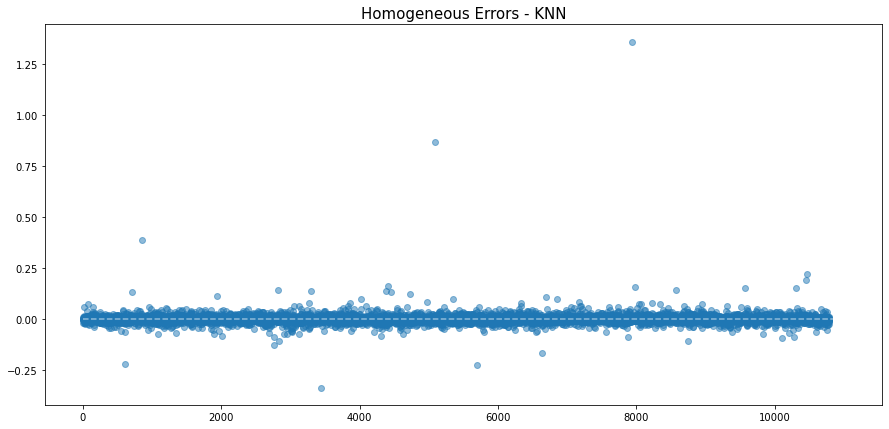

In [26]:
plt.figure(figsize=(15,7))
#Errors#
ax_x= performance['True Value']
ax_y= performance['Prediction']
yerr= performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - KNN', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);


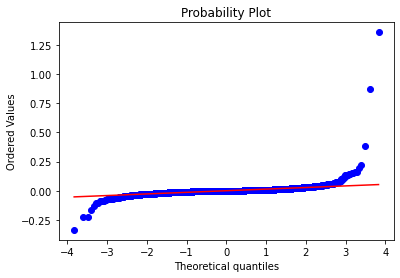

In [27]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt);

The model presents some outliers, with most of the predictions being good. It vould be enhanced with some cleaning of the data though.


In [28]:
#Predictions#
preds = lrLog_model.predict(X_test_log)

#Performance#
LR_log_performance = pd.DataFrame({ 'True Value': np.exp(y_test_log),
                                   'Prediction': np.exp(preds),
                                   'Error': np.exp(y_test_log) - np.exp(preds)})

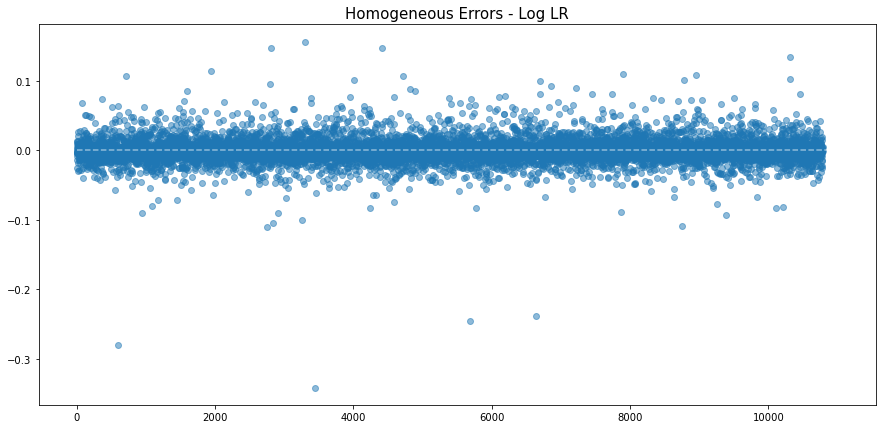

In [29]:
plt.figure(figsize=(15,7))
#Errors#
ax_x= LR_log_performance['True Value']
ax_y= LR_log_performance['Prediction']
yerr= LR_log_performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - Log LR', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);

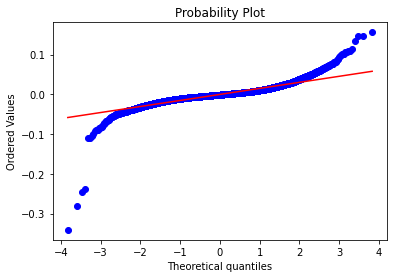

In [31]:
#Quantile-quantile plot#
probplot(yerr, dist='norm', plot=plt);


## Model Comparison

In [32]:
pd.DataFrame({'Linear Regression':[score_lr],
              'Log_Linear Regression': [score_log],
              'KNN Regression': [score_knn]})

,Linear Regression,Log_Linear Regression,KNN Regression
0,0.953425,0.998848,0.997853
